<a href="https://colab.research.google.com/github/alecbidaran/Pytorch_excersies/blob/main/Image_noising_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.datasets import make_swiss_roll
import torch 
import torch.nn as nn
import torch.optim as optim

In [ ]:
def make_beta_schedule(schedule='linear', n_timesteps=10000, start=1e-5, end=1e-3):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps).cuda()
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps).cuda() ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps).cuda()
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

n_steps=100

In [ ]:
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-3, end=1e-1)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0).cuda()
alphas_prod_p = torch.cat([torch.tensor([1]).float().cuda(), alphas_prod[:-1]], 0).cuda()
alphas_bar_sqrt = torch.sqrt(alphas_prod).cuda()
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
alphas_bar_sqrt

tensor([0.9994, 0.9987, 0.9981, 0.9974, 0.9967, 0.9960, 0.9952, 0.9945, 0.9936,
        0.9928, 0.9919, 0.9909, 0.9899, 0.9888, 0.9877, 0.9865, 0.9851, 0.9837,
        0.9822, 0.9805, 0.9787, 0.9767, 0.9746, 0.9722, 0.9696, 0.9668, 0.9637,
        0.9603, 0.9565, 0.9524, 0.9478, 0.9428, 0.9374, 0.9313, 0.9247, 0.9175,
        0.9096, 0.9010, 0.8917, 0.8815, 0.8705, 0.8587, 0.8459, 0.8323, 0.8178,
        0.8024, 0.7861, 0.7690, 0.7511, 0.7325, 0.7132, 0.6933, 0.6729, 0.6521,
        0.6310, 0.6097, 0.5883, 0.5668, 0.5455, 0.5243, 0.5033, 0.4827, 0.4624,
        0.4426, 0.4233, 0.4045, 0.3862, 0.3685, 0.3515, 0.3350, 0.3192, 0.3039,
        0.2893, 0.2753, 0.2619, 0.2490, 0.2367, 0.2250, 0.2138, 0.2032, 0.1930,
        0.1833, 0.1741, 0.1653, 0.1569, 0.1490, 0.1414, 0.1343, 0.1274, 0.1210,
        0.1148, 0.1089, 0.1034, 0.0981, 0.0931, 0.0883, 0.0838, 0.0795, 0.0755,
        0.0716], device='cuda:0')

In [ ]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape).cuda()

In [ ]:
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise=torch.rand_like(x_0).cuda()
    alpha_t=extract(alphas_bar_sqrt,t,x_0)
    alpha_1mt=extract(one_minus_alphas_bar_sqrt,t,x_0)
    return (alpha_t*x_0+alpha_1mt*noise)

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [ ]:
dataset=CIFAR10(root='/',train=True,download=True,transform=transforms.ToTensor())

Files already downloaded and verified


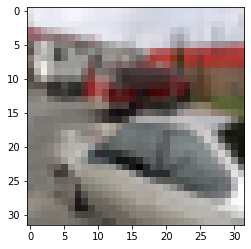

In [ ]:
img,_=dataset[-1]
plt.imshow(img.permute(1,2,0))

In [ ]:
t=torch.tensor([1*10]).cuda()
reshape = [t.shape[0]] + [1] * (len(img.shape) - 1)
torch.gather(alphas_bar_sqrt,0,t)


tensor([0.9919], device='cuda:0')

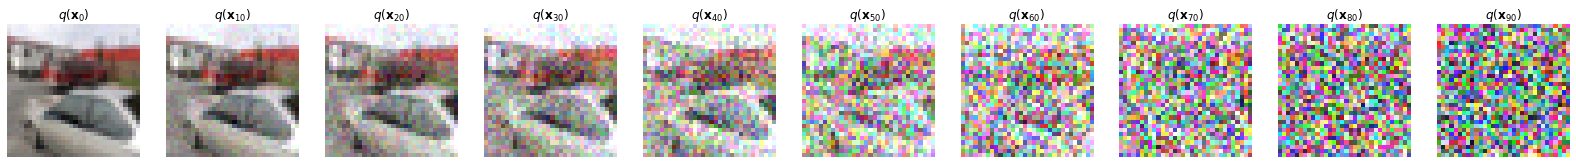

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
  q_i=q_sample(img.cuda(),torch.tensor([i*10]).cuda())
  axs[i].imshow(q_i.permute(1,2,0).cpu());
  axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

In [ ]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

In [ ]:
import torch.nn.functional as F
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

In [ ]:
class Noise_model(nn.Module):
  def __init__(self,n_steps):
    super(Noise_model,self).__init__()
    self.conv=nn.Sequential(nn.Conv2d(3,32,kernel_size=(3,3),stride=2,padding=1),
                            nn.BatchNorm2d(32),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(32,64,kernel_size=(3,3),stride=2,padding=1),
                            nn.BatchNorm2d(64),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(64,128,kernel_size=(3,3),stride=2,padding=1),
                            nn.BatchNorm2d(128),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(128,256,kernel_size=(3,3),stride=2,padding=1),
                            nn.BatchNorm2d(256),
                            nn.ReLU(inplace=True),)
  
    self.flatten=nn.Flatten()
    self.l1=ConditionalLinear(1024,1024,n_steps)
    self.l2=ConditionalLinear(1024,1024,n_steps)
    self.mean=torch.nn.Linear(1024,1024*3)
    self.var=torch.nn.Linear(1024,1)
  def forward(self,x,y):
    x=self.conv(x)
    x=self.flatten(x)
    x=self.l1(x,y)
    x=self.l2(x,y)
    mean=self.mean(x).reshape(-1,3,32,32)
    var=self.var(x).reshape(-1,1,1,1)
    return mean,var


In [ ]:
def p_mean_variance(model, x, t):
    model.train()
    # Go through model
    out = model(x.clone().detach(),t)
    # Extract the mean and variance
    mean, log_var = out
    var = torch.exp(log_var)
    return mean, log_var

In [ ]:
t = torch.randint(0, n_steps, size=(128 // 2 + 1,)).cuda()
t = torch.cat([t, n_steps - t - 1], dim=0)[:128].long().cuda()
mean,var=p_mean_variance(model,torch.tensor(img[None]).cuda(),t)
var.shape
x_t=q_sample(batch_x,t)
mean,var=q_posterior_mean_variance(batch_x,x_t,t)


<ipython-input-240-a8694a808780>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean,var=p_mean_variance(model,torch.tensor(img[None]).cuda(),t)


RuntimeError: ignored

In [ ]:
from torchsummary import summary
model=Noise_model(100).cuda()

In [ ]:
def p_sample(model,x,t):
  t=torch.tensor([t]).cuda()
  alpha=extract(alphas,t,x)
  alpha=alpha.cuda()
  one_min_alpha_sqrt=extract(one_minus_alphas_bar_sqrt,t,x)
  epsilon=(1.-alpha)/(one_min_alpha_sqrt.cuda())
  eptheta,_=model(x,t)
  mean=(1./alpha.sqrt())*(x-epsilon*eptheta)
  z=torch.rand_like(x).cuda()
  sigma_t=extract(betas,t,x)
  p=mean+sigma_t*z
  return (p) 

In [ ]:
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape).cuda()
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

In [ ]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5*(torch.tensor(1+np.log(2*np.pi))).cuda())+ 0.5 * torch.log(val).cuda()

In [ ]:
def compute_loss(true_mean, true_var, model_mean, model_var):
    # the KL divergence between model transition and posterior from data
    KL = normal_kl(true_mean, true_var, model_mean, model_var).float().cuda()
    # conditional entropies H_q(x^T|x^0) and H_q(x^1|x^0)
    H_start = entropy(betas[0].float()).float()
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(alphas))).float().cuda()
    H_end = entropy(beta_full_trajectory.float()).float()
    H_prior = entropy(torch.tensor([1.])).float()
    negL_bound = KL * n_steps + H_start.cuda() - H_end.cuda() + H_prior.cuda()
    # the negL_bound if this was an isotropic Gaussian model of the data
    negL_gauss = entropy(torch.tensor([1.])).float()
    negL_diff = negL_bound - negL_gauss.cuda()
    L_diff_bits = negL_diff / np.log(2.)
    L_diff_bits_avg = L_diff_bits.mean()
    return L_diff_bits_avg

In [ ]:
def loss_likelihood_bound(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,)).cuda()
    t = torch.cat([t, n_steps - t - 1], dim=0,)[:batch_size].long().cuda()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the loss
    return compute_loss(true_mean, true_var, model_mean, model_var)

251.97703552246094


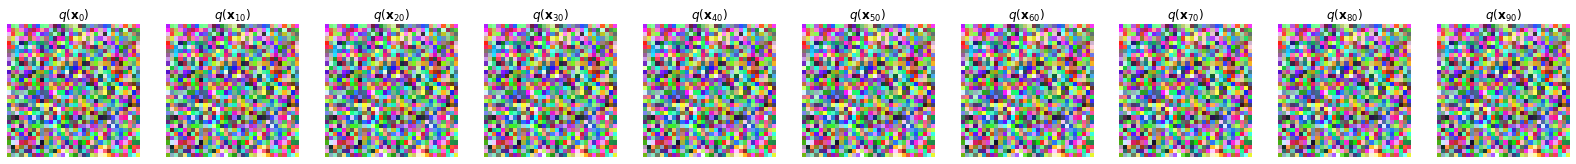

In [ ]:
model = Noise_model(n_steps=100).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#dataset = torch.tensor(data.T).float()
batch_size = 128
for t in range(5001):
    # X is a torch Variable
    permutation = torch.randperm(1000).cuda()
    for i in range(0, 1000, batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x= torch.cat([dataset[indice][0][None] for indice in indices],axis=0).cuda()
        # Compute the loss.
        loss = loss_likelihood_bound(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
    # Print loss
    if (t % 1000 == 0):
        print(loss.detach().item())
        x_seq = p_sample_loop(model,img[None].shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(10):
            cur_x = x_seq[i * 10].detach().cpu()
            axs[i].imshow(q_i.permute(1,2,0).cpu());
            axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')
        plt.show()

In [ ]:
len(dataset)

50000